In [1]:
%matplotlib inline

In [2]:
qvarn = 'http://localhost:9001'
jsonb_91_no_alog = 'http://localhost:9002'
jsonb_91_alog = 'http://localhost:9003'
jsonb_92_no_alog = 'http://localhost:9004'
jsonb_92_alog = 'http://localhost:9005'
planb = 'http://localhost:9006'

names = {
    qvarn: 'qvarn',
    jsonb_91_no_alog: 'jsonb_91_no_alog',
    jsonb_91_alog: 'jsonb_91_alog',
    jsonb_92_no_alog: 'jsonb_92_no_alog',
    jsonb_92_alog: 'jsonb_92_alog',
    planb: 'planb',
}
backends = qvarn, jsonb_91_no_alog, jsonb_91_alog, jsonb_92_no_alog, jsonb_92_alog, planb

In [3]:
import collections
import configparser
import datetime
import faker
import hashlib
import itertools
import jwt
import logging as log
import os
import pandas as pd
import pathlib
import random
import requests
import seaborn as sns
import statistics
import sys
import time
import tqdm
import ujson as json
from IPython.display import display

log.basicConfig(filename='/tmp/performance-testing.log', level=log.DEBUG)
log.getLogger('urllib3').setLevel(log.ERROR)

sns.set(style="whitegrid", font_scale=2, rc={
    'figure.figsize': (16, 8),
})

claims = {
    'iss': 'https://auth-jsonb.alpha.vaultit.org',
    'sub': '',
    'aud': '',
    'exp': (datetime.datetime.now() + datetime.timedelta(days=10)).timestamp(),
    'scope': ' '.join([
        scope % resource_type
        for scope in (
            'uapi_%s_get',
            'uapi_%s_post',
            'uapi_%s_id_get',
            'uapi_%s_id_put',
            'uapi_%s_id_delete',
            'uapi_%s_search_id_get',
        )
        for resource_type in (
            'orgs',
            'access',
        )
    ]),
}
key = pathlib.Path('../keys/rsa').read_bytes()
token = jwt.encode(claims, key, algorithm='RS512').decode()

session = requests.Session()
session.headers['authorization'] = f'Bearer {token}'
session.headers['cache-control'] = 'no-cache'

fake = faker.Faker()

In [4]:
session.get(f'{qvarn}/version').json()

{
    'api': {'version': '0.82-6.vaultit'},
    'implementation': {'name': 'Qvarn', 'version': '0.82-6.vaultit'},
}

In [5]:
session.get(f'{jsonb_91_no_alog}/version').json()

{
    'api': {'version': '0.91'},
    'implementation': {'name': 'Qvarn', 'version': '0.91'},
}

In [6]:
session.get(f'{jsonb_91_alog}/version').json()

{
    'api': {'version': '0.91'},
    'implementation': {'name': 'Qvarn', 'version': '0.91'},
}

In [7]:
session.get(f'{jsonb_92_no_alog}/version').json()

{
    'api': {'version': '0.92'},
    'implementation': {'name': 'Qvarn', 'version': '0.92'},
}

In [8]:
session.get(f'{jsonb_92_alog}/version').json()

{
    'api': {'version': '0.92'},
    'implementation': {'name': 'Qvarn', 'version': '0.92'},
}

In [9]:
session.get(f'{planb}/version').json()

{
    'api': {'version': '0.82-5.vaultit'},
    'implementation': {'name': 'Qvarn PlanB', 'version': '0.0.1'},
}

In [10]:
class Test:
    
    def __init__(self, n, backend, *args, **kwargs):
        self.backend = backend
        self.total = n
        self.prepare(*args, **kwargs)
        
    def prepare(self):
        pass
    
    def __iter__(self):
        yield from range(self.total)
            
    def __call__(self, item):
        raise NotImplementedError()

In [11]:
def stats_table(backends, counts, times, runs, failed):
    frame = pd.DataFrame(collections.OrderedDict([
        (('iterations', 'total'), [runs[x].total for x in backends]),
        (('iterations', 'failed'), [failed[x] for x in backends]),
        (('time in seconds', 'total'), [sum(times[x]) if times[x] else None for x in backends]),
        (('time in seconds', 'mean'), [statistics.mean(times[x]) if times[x] else None for x in backends]),
        (('time in seconds', 'median'), [statistics.median(times[x]) if times[x] else None for x in backends]),
        (('time in seconds', 'stdev'), [statistics.stdev(times[x]) if times[x] else None for x in backends]),
        (('', 'n resources'), [counts[x] for x in backends]),
    ]), index=[names[x] for x in backends])
    frame = frame.sort_values(('time in seconds', 'median'))
    median = frame[('time in seconds', 'median')]
    frame[('', 'n times slower')] = (median / median.min()).map('{:.1f}'.format)
    return frame

In [12]:
def violin_plot(backends, times, size):
    frame = pd.DataFrame(collections.OrderedDict([
        (names[x], times[x] + [None for i in range(size - len(times[x]))])
        for x in backends
    ]))
    ax = sns.violinplot(data=frame, orient='h')
    ax.set_xscale('log')
    ax.set_xlabel("time in seconds (log scale)")
    return ax

In [13]:
summary = pd.DataFrame({}, index=[names[x] for x in backends])

In [14]:
def measure(n, backends, test, *args, **kwargs):
    global summary
    
    counts = {
        x: len(session.get(f'{x}/orgs').json()['resources'])
        for x in backends
    }
    failed = {backend: 0 for backend in backends}
    times = collections.defaultdict(list)
    runs = {}
    for backend in backends:
        run = runs[backend] = test(n, backend, *args, **kwargs)
        name = names[backend]
        for item in tqdm.tqdm_notebook(run, name, total=run.total, leave=False):
            start = time.monotonic()
            try:
                resp = run(item)
            except KeyboardInterrupt:
                raise
            except:
                log.exception('error')
                ok = False
                resp = None
            else:
                ok = resp.ok
            delta = time.monotonic() - start
            if ok:
                times[backend].append(delta)
            else:
                if resp:
                    log.error('stauts: %d, response: %s', resp.status_code, resp.text)
                failed[backend] += 1
                
    frame = stats_table(backends, counts, times, runs, failed)
    display(frame)
    
    summary = pd.concat([summary, frame[('', 'n times slower')].astype(float)], axis=1, ignore_index=True)
    
    size = max(len(times[x]) for x in backends)
    if size > 1:
        ax = violin_plot(backends, times, size)
        display(ax)

In [15]:
def get_new_id(resource_type):
    type_field = hashlib.sha512(resource_type.encode()).hexdigest()[:4]
    random_field = os.urandom(16).hex()
    checksum_field = hashlib.sha512((type_field + random_field).encode()).hexdigest()[:8]
    return '-'.join([type_field, random_field, checksum_field])

get_new_id('org')

'f392-9320139dc00d498dc544729ff5c7535d-e0ef6cd0'

In [16]:
with open('orgs.jsonl', 'w') as f:
    for i in tqdm.tqdm_notebook(range(5_000)):
        org =  {
            'type': 'org',
            'country': 'FI',
            'names': (
                [fake.company(), fake.catch_phrase()]
                if random.randint(0, 50) == 42 else
                [fake.company()]
            ),
            'gov_org_ids': [
                {
                    'country': 'FI',
                    'org_id_type': 'registration_number',
                    'gov_org_id': fake.ssn(),
                }
            ],
            'contacts': [
                {
                    'contact_type': 'phone',
                    'phone_number': fake.phone_number(),
                    'full_address': fake.address(),
                    'contact_timestamp': str(time.time()),
                    'country': fake.country_code(),
                    'contact_roles': [],
                    'address_lines': fake.address().splitlines(),
                    'post_code': None,
                    'post_area': None,
                    'einvoice_operator': None,
                    'contact_source': 'qvarn-genarator',
                    'einvoice_address': None,
                    'email_address': None,
                }
                for i in range(random.randint(1, 5))
            ],
        }
        json.dump(org, f, ensure_ascii=False)
        f.write('\n')

In [17]:
def read_orgs():
    with open('orgs.jsonl') as f:
        yield from map(json.loads, f)
            
def gen_orgs(backends):
    return {backend: read_orgs() for backend in backends}
    
orgs = gen_orgs(backends)

In [18]:
def delete_orgs(backends):
    result = {}
    for backend in backends:
        success = failure = 0
        for resource in tqdm.tqdm_notebook(session.get(f'{backend}/orgs').json()['resources'], f'delete: {names[backend]}', leave=False):
            try:
                resp = session.delete(f'{backend}/orgs/{resource["id"]}')
            except requests.ConnectionError:
                log.exception('error while deleteing %s', resource['id'])
                failure += 1
            else:
                if resp.ok:
                    success += 1
                else:
                    failure += 1
        result[backend] = {'success': success, 'failure': failure}
    return result
            
            
def create_orgs(n, backends):
    result = {}
    for backend in backends:
        success = failure = 0
        for resource in tqdm.tqdm_notebook(itertools.islice(orgs[backend], n), f'create: {names[backend]}', total=n, leave=False):
            try:
                resp = session.post(f'{backend}/orgs', json=resource)
            except requests.ConnectionError:
                log.exception('error while creating resource')
                failure += 1
            else:
                if resp.ok:
                    success += 1
                else:
                    failure += 1
        result[backend] = {'success': success, 'failure': failure}
    return result
            

def reset(n, backends, delete=True):
    global orgs
    orgs = gen_orgs(backends)
    deleted = delete_orgs(backends) if delete else {x: {'success': 0, 'failure': 0} for x in backends}
    created = create_orgs(n, backends) if n > 0 else {x: {'success': 0, 'failure': 0} for x in backends}
    return pd.DataFrame(collections.OrderedDict([
        (('delete orgs', 'deleted'), [deleted[x]['success'] for x in backends]),
        (('delete orgs', 'failed'), [deleted[x]['failure'] for x in backends]),
        (('create orgs', 'created'), [created[x]['success'] for x in backends]),
        (('create orgs', 'failed'), [created[x]['failure'] for x in backends]),
        (('', 'orgs'), [len(session.get(f'{x}/orgs').json()['resources']) for x in backends]),
    ]), index=[names[x] for x in backends])
    
reset(0, backends)

delete orgs        create orgs            
                     deleted failed     created failed orgs
qvarn                   1095      2           0      0    2
jsonb_91_no_alog        1100      0           0      0    0
jsonb_91_alog           1100      0           0      0    0
jsonb_92_no_alog        1100      0           0      0    0
jsonb_92_alog           1100      0           0      0    0
planb                   1100      0           0      0    0

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        1.475979  0.014760  0.014176   
qvarn                   100      1        3.790447  0.038287  0.036524   
jsonb_92_no_alog        100      0        4.387475  0.043875  0.043251   
jsonb_91_no_alog        100      0        4.734542  0.047345  0.046015   
jsonb_92_alog           100      0        5.484761  0.054848  0.054619   
jsonb_91_alog           100      0        6.371266  0.063713  0.061557   

                                                       
                     stdev n resources n times slower  
planb             0.002875           0            1.0  
qvarn             0.007612           2            2.6  
jsonb_92_no_alog  0.005010           0            3.1  
jsonb_91_no_alog  0.005253           0            3.2  
jsonb_92_alog     0.005587           0            3.9  
jsonb_91_alog     0.011877           0            4.3

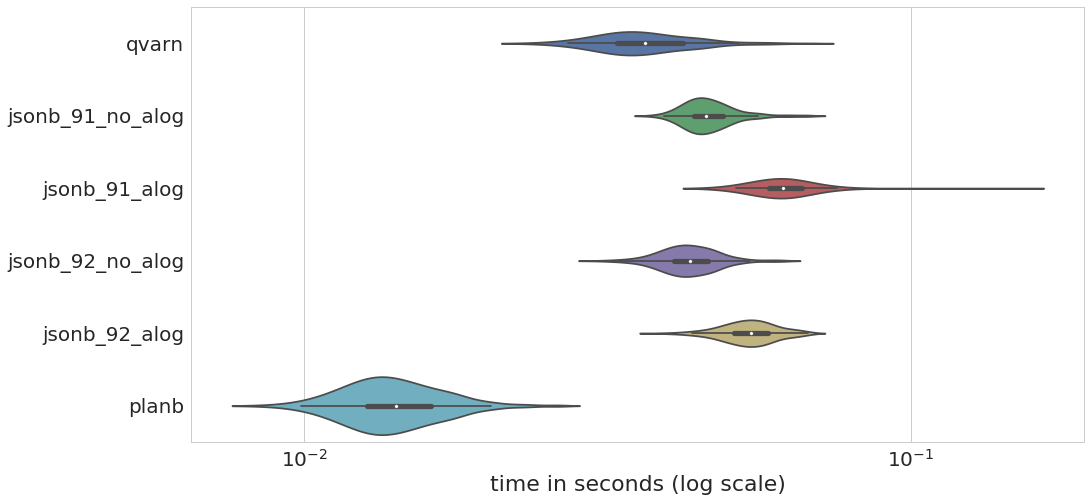

In [19]:
class CreateOrgs(Test):
    
    def __iter__(self):
        yield from itertools.islice(orgs[self.backend], self.total)
    
    def __call__(self, item):
        return session.post(f'{self.backend}/orgs', json=org)
    
measure(100, backends, CreateOrgs)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        1.983603  0.019836  0.019082   
jsonb_92_no_alog        100      0        3.799127  0.037991  0.037830   
qvarn                   100      0        3.975797  0.039758  0.039703   
jsonb_91_no_alog        100      0        4.078000  0.040780  0.040329   
jsonb_92_alog           100      0        4.905717  0.049057  0.048888   
jsonb_91_alog           100      0        5.517915  0.055179  0.054810   

                                                       
                     stdev n resources n times slower  
planb             0.003861         100            1.0  
jsonb_92_no_alog  0.006878         100            2.0  
qvarn             0.005189         101            2.1  
jsonb_91_no_alog  0.007158         100            2.1  
jsonb_92_alog     0.006974         100            2.6  
jsonb_91_alog     0.007876         100            2.9

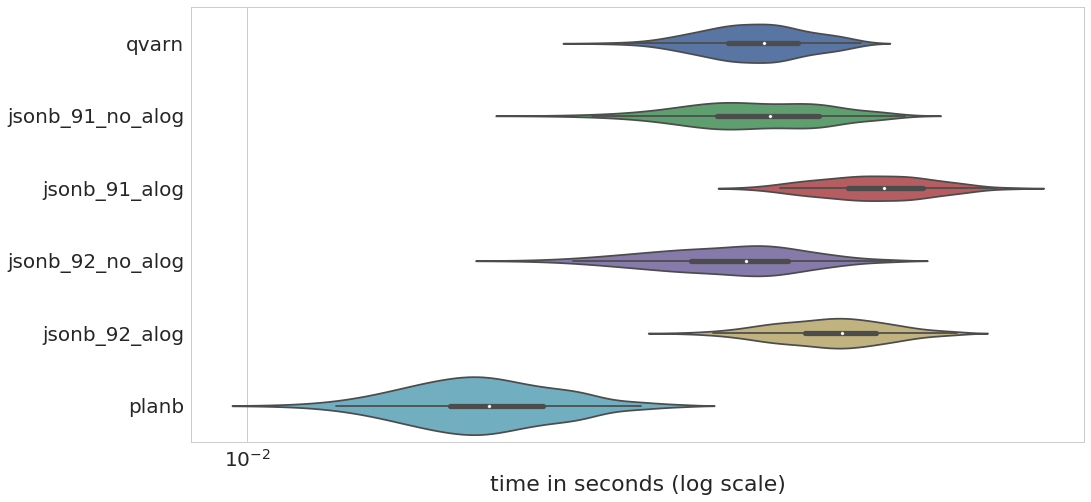

In [20]:
class UpdateOrgs(Test):
    
    def __iter__(self):
        for resource in session.get(f'{self.backend}/orgs').json()['resources'][:self.total]:
            try:
                yield session.get(f'{self.backend}/orgs/{resource["id"]}').json()
            except requests.ConnectionError:
                pass
        
    def __call__(self, resource):
        resource = dict(next(orgs[self.backend]), id=resource['id'], revision=resource['revision'])
        return session.put(f'{self.backend}/orgs/{resource["id"]}', json=resource)
    
measure(100, backends, UpdateOrgs)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        1.093579  0.010936  0.010266   
jsonb_92_no_alog        100      0        1.406071  0.014061  0.013504   
jsonb_91_no_alog        100      0        1.632242  0.016322  0.015855   
jsonb_92_alog           100      0        2.725313  0.027253  0.025810   
jsonb_91_alog           100      0        3.265606  0.032656  0.030748   
qvarn                   101      0        3.260521  0.032282  0.031253   

                                                       
                     stdev n resources n times slower  
planb             0.002557         100            1.0  
jsonb_92_no_alog  0.002593         100            1.3  
jsonb_91_no_alog  0.003503         100            1.5  
jsonb_92_alog     0.005363         100            2.5  
jsonb_91_alog     0.011690         100            3.0  
qvarn             0.005276         101            3.0

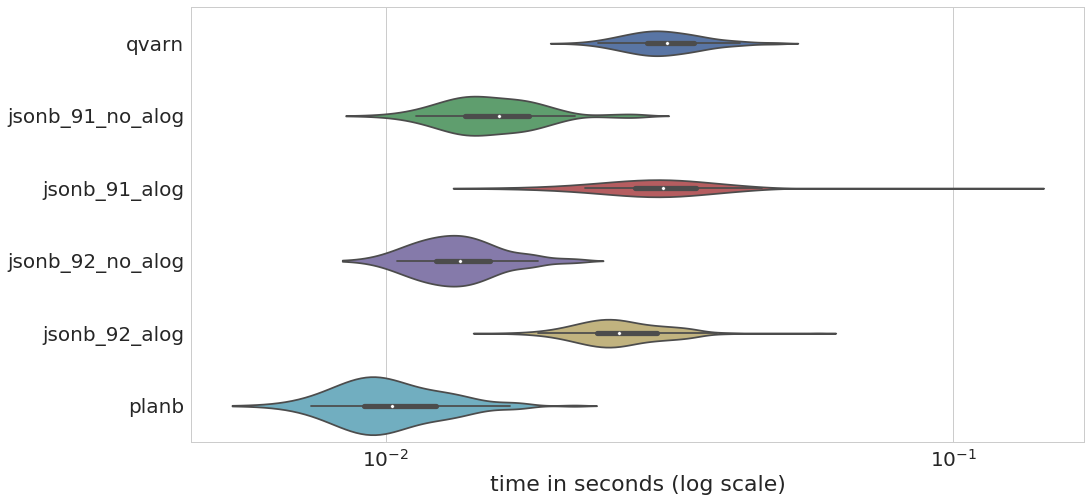

In [21]:
class DeleteResources(Test):
    
    def prepare(self, resource_type):
        self.resource_type = resource_type
        self.resp = session.get(f'{self.backend}/{resource_type}').json()
        self.total = len(self.resp['resources'])
        
    def __iter__(self):
        yield from iter(self.resp['resources'])
            
    def __call__(self, resource):
        return session.delete(f'{self.backend}/{self.resource_type}/{resource["id"]}')

measure(None, backends, DeleteResources, 'orgs')

In [22]:
reset(100, backends)

delete orgs        create orgs            
                     deleted failed     created failed orgs
qvarn                      0      0          99      1   99
jsonb_91_no_alog           0      0         100      0  100
jsonb_91_alog              0      0         100      0  100
jsonb_92_no_alog           0      0         100      0  100
jsonb_92_alog              0      0         100      0  100
planb                      0      0         100      0  100

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        1.003766  0.010038  0.009605   
qvarn                   100      0        1.272271  0.012723  0.011445   
jsonb_92_no_alog        100      0        2.769862  0.027699  0.026291   
jsonb_91_no_alog        100      0        3.125002  0.031250  0.031248   
jsonb_92_alog           100      0       13.937571  0.139376  0.140182   
jsonb_91_alog           100      0      154.624619  1.546246  1.579872   

                                                       
                     stdev n resources n times slower  
planb             0.002337         100            1.0  
qvarn             0.006130          99            1.2  
jsonb_92_no_alog  0.006619         100            2.7  
jsonb_91_no_alog  0.005381         100            3.3  
jsonb_92_alog     0.011731         100           14.6  
jsonb_91_alog     0.144767         100          164.5

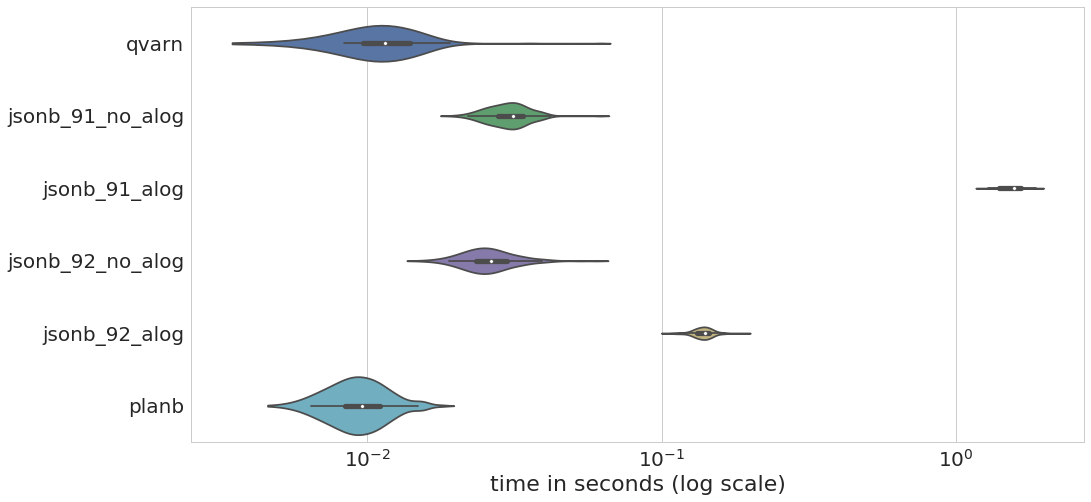

In [23]:
class GetAll(Test):
    
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs')
    
measure(100, backends, GetAll)

In [24]:
pd.DataFrame(collections.OrderedDict([
    (names[backend], len(session.get(f'{backend}/access').json()['resources']))
    for backend in backends
]), index=['number of access log entries']).T

,number of access log entries
qvarn,0
jsonb_91_no_alog,0
jsonb_91_alog,47700
jsonb_92_no_alog,0
jsonb_92_alog,3720
planb,0


iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        3.216619  0.032166  0.030703   
jsonb_92_no_alog        100      0       22.362988  0.223630  0.221579   
jsonb_92_alog           100      0       34.170776  0.341708  0.340849   
jsonb_91_no_alog        100      0       34.241463  0.342415  0.342204   
qvarn                   100      0       99.969237  0.999692  0.997076   
jsonb_91_alog           100      0      170.713566  1.707136  1.707337   

                                                       
                     stdev n resources n times slower  
planb             0.009206         100            1.0  
jsonb_92_no_alog  0.015993         100            7.2  
jsonb_92_alog     0.022749         100           11.1  
jsonb_91_no_alog  0.019058         100           11.1  
qvarn             0.040052          99           32.5  
jsonb_91_alog     0.073618         100           55.6

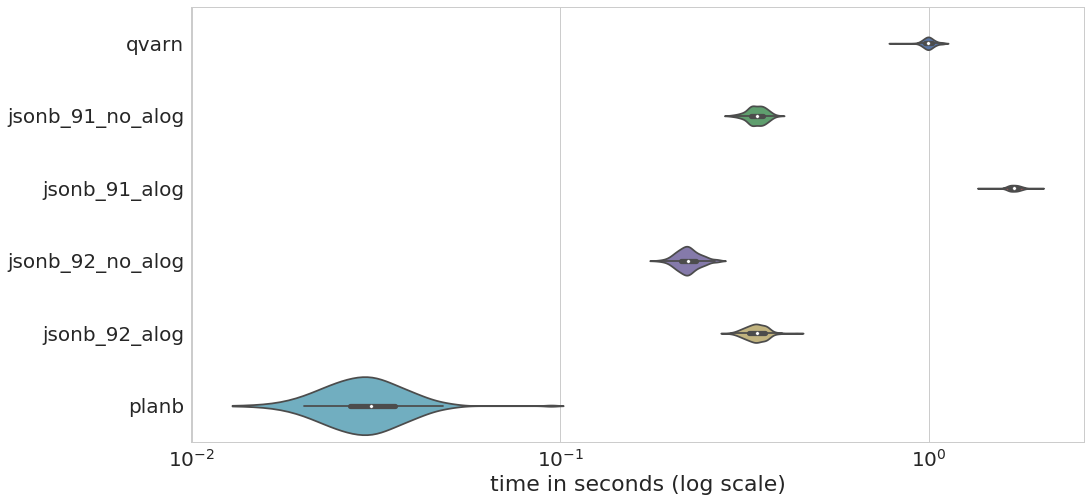

In [25]:
class SearchShowAll(Test):
    
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/show_all')

measure(100, backends, SearchShowAll)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        2.457648  0.024576  0.023922   
qvarn                   100      0       17.709698  0.177097  0.175797   
jsonb_92_no_alog        100      0       21.706345  0.217063  0.215255   
jsonb_91_no_alog        100      0       28.697718  0.286977  0.283966   
jsonb_92_alog           100      0       33.322730  0.333227  0.332125   
jsonb_91_alog           100      0      165.945939  1.659459  1.659507   

                                                       
                     stdev n resources n times slower  
planb             0.004239         100            1.0  
qvarn             0.014934          99            7.3  
jsonb_92_no_alog  0.014073         100            9.0  
jsonb_91_no_alog  0.017059         100           11.9  
jsonb_92_alog     0.019049         100           13.9  
jsonb_91_alog     0.058020         100           69.4

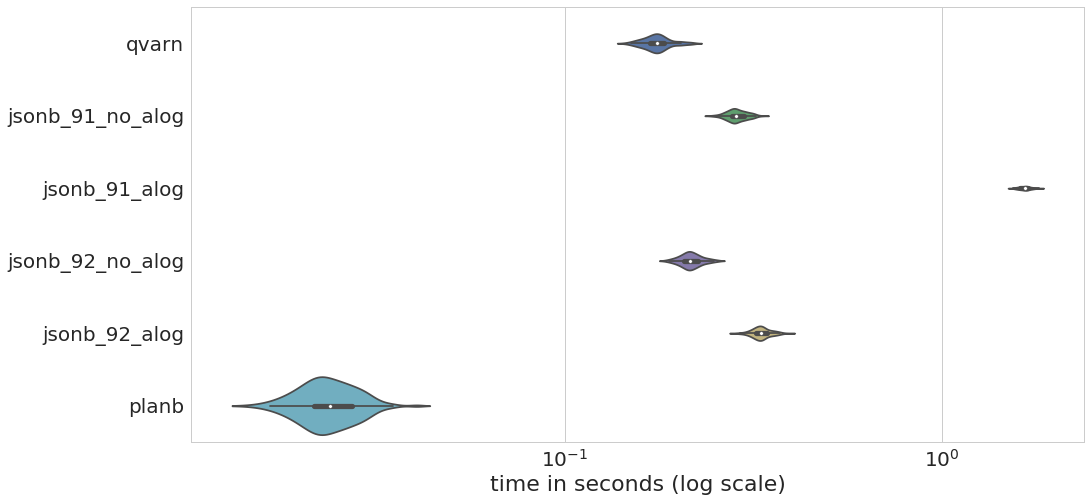

In [26]:
class SearchShow(Test):
    
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/show/names')

measure(100, backends, SearchShow)

In [27]:
reset(1000, backends, delete=False)

delete orgs        create orgs             
                     deleted failed     created failed  orgs
qvarn                      0      0         999      1  1098
jsonb_91_no_alog           0      0        1000      0  1100
jsonb_91_alog              0      0        1000      0  1100
jsonb_92_no_alog           0      0        1000      0  1100
jsonb_92_alog              0      0        1000      0  1100
planb                      0      0        1000      0  1100

iterations        time in seconds                        \
                      total failed           total       mean     median   
qvarn                    10      0        0.186223   0.018622   0.016839   
planb                    10      0        0.386847   0.038685   0.038902   
jsonb_92_no_alog         10      0        2.037382   0.203738   0.198803   
jsonb_91_no_alog         10      0        2.280513   0.228051   0.229950   
jsonb_92_alog            10      0       12.112362   1.211236   1.186890   
jsonb_91_alog            10      0      145.135115  14.513512  14.513658   

                                                       
                     stdev n resources n times slower  
qvarn             0.005710        1098            1.0  
planb             0.005298        1100            2.3  
jsonb_92_no_alog  0.040960        1100           11.8  
jsonb_91_no_alog  0.014386        1100           13.7  
jsonb_92_alog     0.062181        1100           70.5  
jsonb_91_alog     0.115567        1100          861.9

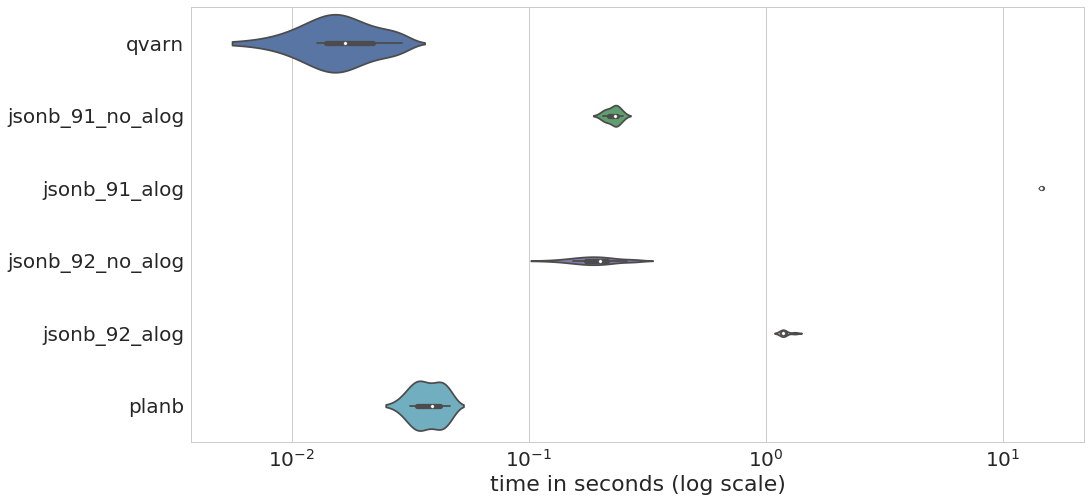

In [28]:
measure(10, backends, GetAll)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        0.841854  0.008419  0.008164   
qvarn                   100      1        1.912746  0.019321  0.018676   
jsonb_92_no_alog        100      0      243.871824  2.438718  2.424037   
jsonb_92_alog           100      0      250.443279  2.504433  2.491969   
jsonb_91_no_alog        100      0      313.932744  3.139327  3.113238   
jsonb_91_alog           100      0      344.364726  3.443647  3.404668   

                                                       
                     stdev n resources n times slower  
planb             0.001745        1100            1.0  
qvarn             0.003627        1098            2.3  
jsonb_92_no_alog  0.125033        1100          296.9  
jsonb_92_alog     0.085085        1100          305.2  
jsonb_91_no_alog  0.137839        1100          381.3  
jsonb_91_alog     0.226343        1100          417.0

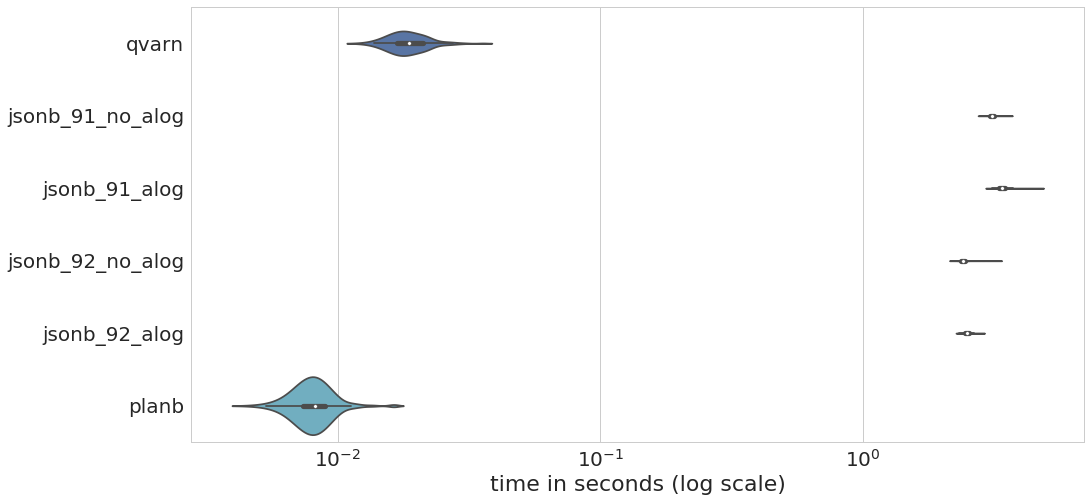

In [29]:
class SearchLimit(Test):
    
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/sort/id/limit/1')
    
measure(100, backends, SearchLimit)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                  1000      0        7.967088  0.007967  0.007620   
jsonb_92_no_alog       1000      0       10.434951  0.010435  0.009956   
jsonb_91_no_alog       1000      0       10.651476  0.010651  0.010193   
jsonb_92_alog          1000      0       24.627045  0.024627  0.023925   
jsonb_91_alog          1000      0       25.665519  0.025666  0.024744   
qvarn                  1000      4       27.963634  0.028076  0.027357   

                                                       
                     stdev n resources n times slower  
planb             0.002851        1100            1.0  
jsonb_92_no_alog  0.002188        1100            1.3  
jsonb_91_no_alog  0.002229        1100            1.3  
jsonb_92_alog     0.003883        1100            3.1  
jsonb_91_alog     0.004596        1100            3.2  
qvarn             0.007127        1098            3.6

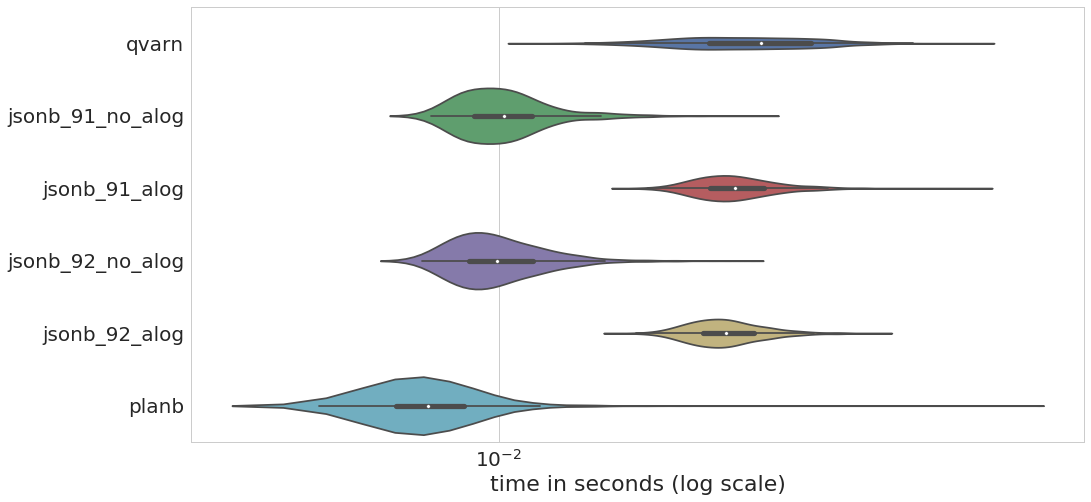

In [30]:
class GetOne(Test):
    
    def prepare(self):
        self.resources = [
            resource['id'] for resource in session.get(f'{self.backend}/orgs').json()['resources']
        ]
        
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/{random.choice(self.resources)}')
    
measure(1000, backends, GetOne)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        0.977047  0.009770  0.009426   
jsonb_92_no_alog        100      0        1.408246  0.014082  0.013400   
jsonb_91_no_alog        100      0        1.458359  0.014584  0.014002   
qvarn                   100      0        1.920153  0.019202  0.018672   
jsonb_92_alog           100      0        2.806551  0.028066  0.026940   
jsonb_91_alog           100      0        3.143512  0.031435  0.029040   

                                                       
                     stdev n resources n times slower  
planb             0.002351        1100            1.0  
jsonb_92_no_alog  0.002961        1100            1.4  
jsonb_91_no_alog  0.003129        1100            1.5  
qvarn             0.003232        1098            2.0  
jsonb_92_alog     0.004965        1100            2.9  
jsonb_91_alog     0.008457        1100            3.1

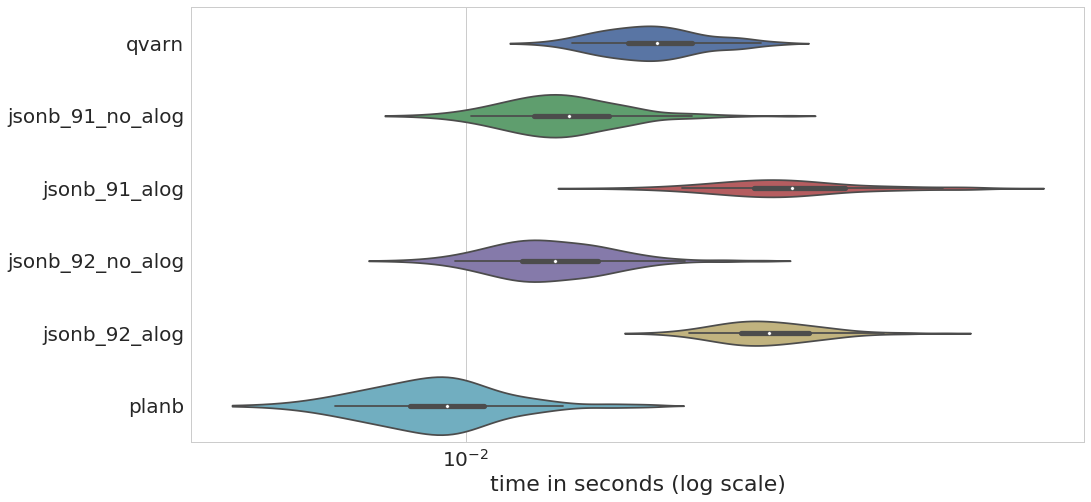

In [31]:
class SearchExact(Test):
    
    def prepare(self):
        self.gov_org_ids = [
            resource['gov_org_ids'][0]['gov_org_id'] for resource in (
                session.get(f'{self.backend}/orgs/search/show/gov_org_ids').
                json()['resources']
            )
        ]
        
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/exact/gov_org_id/{random.choice(self.gov_org_ids)}')
    
measure(100, backends, SearchExact)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        1.519250  0.015193  0.014920   
qvarn                   100      0        1.932325  0.019323  0.018831   
jsonb_92_no_alog        100      0        3.124500  0.031245  0.030458   
jsonb_91_no_alog        100      0        3.332848  0.033328  0.031983   
jsonb_92_alog           100      0       10.774858  0.107749  0.105521   
jsonb_91_alog           100      0       45.919845  0.459198  0.452605   

                                                       
                     stdev n resources n times slower  
planb             0.003199        1100            1.0  
qvarn             0.003320        1098            1.3  
jsonb_92_no_alog  0.004205        1100            2.0  
jsonb_91_no_alog  0.005357        1100            2.1  
jsonb_92_alog     0.007243        1100            7.1  
jsonb_91_alog     0.022600        1100           30.3

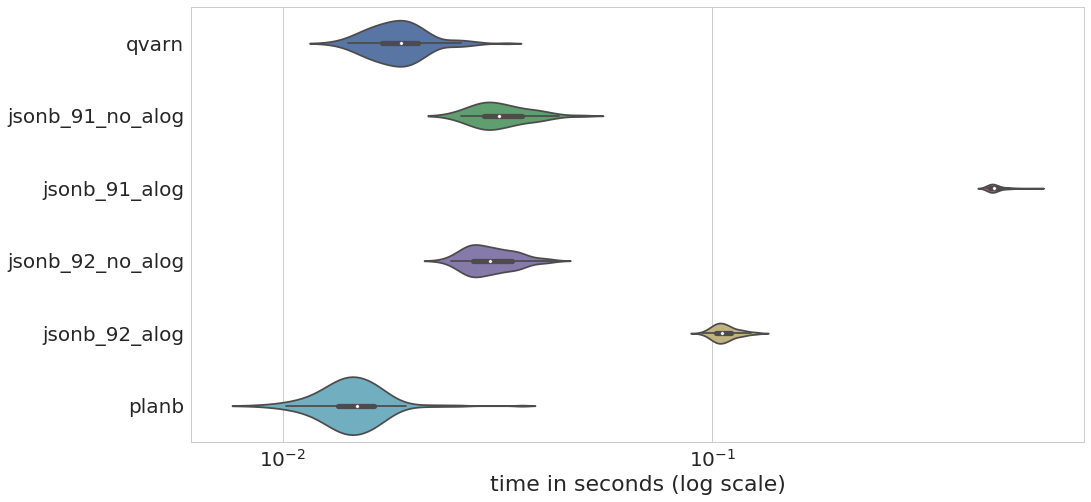

In [32]:
class SearchStartswith(Test):
    
    def prepare(self):
        self.gov_org_ids = [
            resource['gov_org_ids'][0]['gov_org_id'] for resource in (
                session.get(f'{self.backend}/orgs/search/show/gov_org_ids').
                json()['resources']
            )
        ]
        
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/startswith/gov_org_id/{random.choice(self.gov_org_ids)}')
    
measure(100, backends, SearchStartswith)

Text(0.5,0,'n times slower (mean of all tests)')

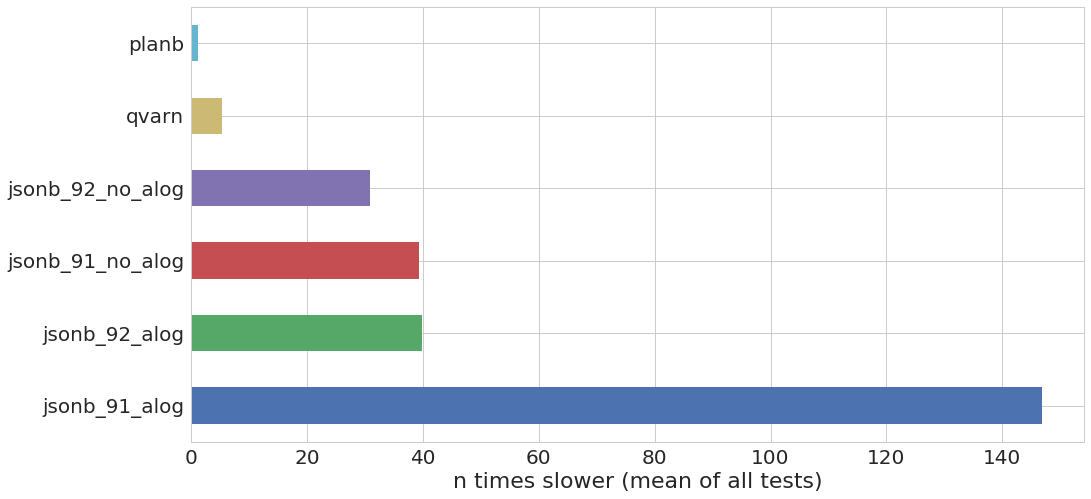

In [33]:
ax = summary.mean(axis=1).sort_values(ascending=False).plot.barh()
ax.set_xlabel('n times slower (mean of all tests)')

Text(0.5,0,'n times slower (median of all tests)')

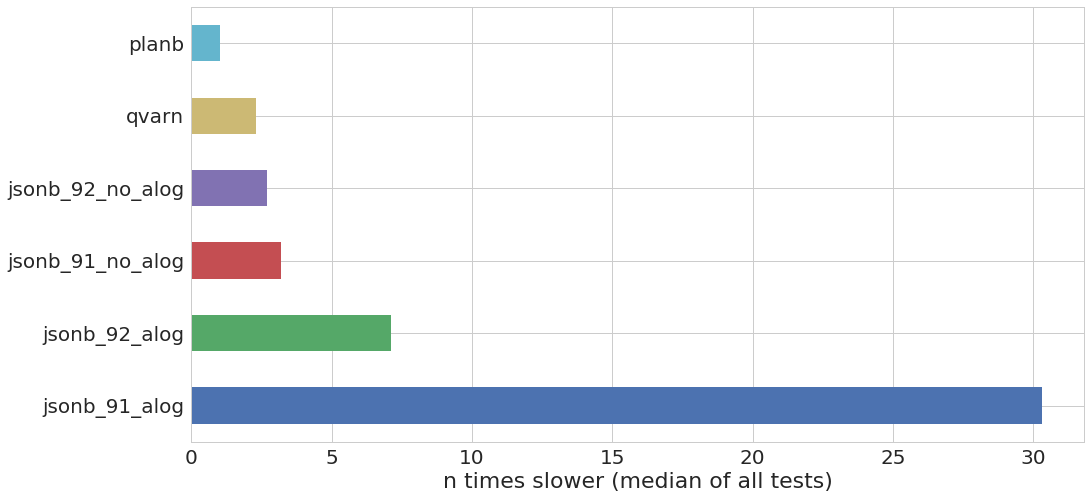

In [34]:
ax = summary.median(axis=1).sort_values(ascending=False).plot.barh()
ax.set_xlabel('n times slower (median of all tests)')

In [35]:
summary

,0,1,2,3,4,5,6,7,8,9,10
jsonb_91_alog,4.3,2.9,3.0,164.5,55.6,69.4,861.9,417.0,3.2,3.1,30.3
jsonb_91_no_alog,3.2,2.1,1.5,3.3,11.1,11.9,13.7,381.3,1.3,1.5,2.1
jsonb_92_alog,3.9,2.6,2.5,14.6,11.1,13.9,70.5,305.2,3.1,2.9,7.1
jsonb_92_no_alog,3.1,2.0,1.3,2.7,7.2,9.0,11.8,296.9,1.3,1.4,2.0
planb,1.0,1.0,1.0,1.0,1.0,1.0,2.3,1.0,1.0,1.0,1.0
qvarn,2.6,2.1,3.0,1.2,32.5,7.3,1.0,2.3,3.6,2.0,1.3
